# This is the ToastBot version that was only trained and evaluated on image data alone. For the complete ToastBot, see `ToastBot.ipynb`

## Import relevant packages

In [1]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
import sklearn
from sklearn.cross_validation import train_test_split
import nltk
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.translate.bleu_score import corpus_bleu
import os
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
from keras.utils import plot_model
from keras.layers.merge import concatenate
import IPython
from tqdm import tqdm_notebook as tqdm

C:\Users\morod\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:55: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  if 'order' in inspect.getargspec(np.copy)[0]:
Using TensorFlow backend.


In [2]:
# the vgg 19 model is used for getting the image features
vgg19_model = VGG19(weights='imagenet')
vgg19_model = Model(inputs=vgg19_model.input, outputs=vgg19_model.get_layer('predictions').output)

# Utility Functions
Many of these functions were inspired from the following tutorial: 
https://medium.com/@dev.elect.iitd/neural-machine-translation-using-word-level-seq2seq-model-47538cba8cd7

In [53]:
def process_data(filename = "./data4K_with_image_features.json", top_comments=10, max_sent=3, max_words=60):
    reddit_data = pd.read_json(filename)
    
    #grab top comments
    reddit_data.comments = [x[:top_comments] for x in reddit_data.comments]

    # expand the data so that each comment has its own row
    lst_col_ga = 'comments'
    df = reddit_data
    reddit_data = pd.DataFrame({
         col:np.repeat(df[col].values, df[lst_col_ga].str.len())
         for col in df.columns.drop(lst_col_ga)}
       ).assign(**{lst_col_ga:np.concatenate(df[lst_col_ga].values)})[df.columns].dropna().reset_index(drop = True)
    
    
    
    # select relevant columns
    reddit_data = reddit_data[["title", "comments", "image_feature", "url"]]
    
    # clean whitespace
    reddit_data.comments = [x.replace("\n", ' ').replace("\t", ' ') for x in reddit_data.comments]
    reddit_data.title = [x.replace("\n", ' ').replace("\t", ' ') for x in reddit_data.title]
    
    # lower the words
    reddit_data.title = reddit_data.title.apply(lambda x: x.lower())
    reddit_data.comments = reddit_data.comments.apply(lambda x: x.lower())
    
    # get only the top sentences
    reddit_data.title = [". ".join(nltk.sent_tokenize(x)[:max_sent]) for x in reddit_data.title]
    reddit_data.comments = [". ".join(nltk.sent_tokenize(x)[:max_sent]) for x in reddit_data.comments]
    # if the sentence is too long, cut it off
    reddit_data.comments = [" ".join((nltk.word_tokenize(x))[:max_words]) for x in reddit_data.comments]
                 
    # remove punctuation
    reddit_data.title = reddit_data.title.apply(lambda x: ''.join(ch for ch in x if ch not in set(string.punctuation)))
    reddit_data.comments = reddit_data.comments.apply(lambda x: ''.join(ch for ch in x if ch not in set(string.punctuation)))
    
    # remove numbers
    remove_numbers = str.maketrans('', '', digits)
    reddit_data.title = reddit_data.title.apply(lambda x: x.translate(remove_numbers))
    reddit_data.comments = reddit_data.comments.apply(lambda x: x.translate(remove_numbers))
                 
    # add start and end tokens
    reddit_data.comments = reddit_data.comments.apply(lambda x : 'START_ '+ x + ' _END')
    
    return reddit_data

def build_tokenizers(reddit, vocab_size=1000):
    # build a vocabulary
    title_vocab = [nltk.word_tokenize(x) for x in reddit.title]
    title_vocab = [i for k in title_vocab for i in k]
    title_vocab = [x[0] for x in Counter(title_vocab).most_common()[:vocab_size]]
    comments_vocab = [nltk.word_tokenize(x) for x in reddit.comments]
    comments_vocab = [i for k in comments_vocab for i in k]
    comments_vocab = [x[0] for x in Counter(comments_vocab).most_common()[:vocab_size]]
    
    # tokenize
    input_words = sorted(list(title_vocab))
    target_words = sorted(list(comments_vocab))
    input_tokenizer = {word: i for i, word in enumerate(input_words)}
    target_tokenizer = {word: i for i, word in enumerate(target_words)}
    
    return input_tokenizer, target_tokenizer    

def get_glove_embeddings(glove_dir):
    embeddings_index = {}
    with open(os.path.join(glove_dir, 'glove.6B.300d.txt'), encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Found {} word vectors'.format(len(embeddings_index)))
    return embeddings_index

def build_embedding_matrix(tokenizer, embeddings, embedding_dim = 300):
    embedding_matrix = np.zeros((len(tokenizer), embedding_dim))
    for word, i in [i for i in tokenizer.items()]:
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

def get_input_target_data(reddit, input_tokenizer, target_tokenizer):
    max_comment_length = np.max([len(l.split(' ')) for l in reddit.comments])
    max_title_length = np.max([len(l.split(' ')) for l in reddit.title])
    
    encoder_input_data = np.zeros((len(reddit.title), max_title_length), dtype='float32')
    decoder_input_data = np.zeros((len(reddit.comments), max_comment_length), dtype='float32')
    decoder_target_data = np.zeros((len(reddit.comments), max_comment_length, len(target_tokenizer)),dtype='float32')
    
    for i, (input_text, target_text) in enumerate(zip(reddit.title, reddit.comments)):
        for t, word in enumerate(input_text.split()):
            if word in input_tokenizer:
                encoder_input_data[i, t] = input_tokenizer[word]
        for t, word in enumerate(target_text.split()):
            if word in target_tokenizer: 
                decoder_input_data[i, t] = target_tokenizer[word]
                if t > 0:
                    # decoder_target_data will be ahead by one timestep
                    decoder_target_data[i, t - 1, target_tokenizer[word]] = 1.
    return encoder_input_data, decoder_input_data, decoder_target_data

def get_image_features(reddit):
    max_comment_length = np.max([len(l.split(' ')) for l in reddit.comments])
    image_features = np.array([np.array(i) for i in reddit.image_feature]).reshape(-1, 1, 1000)
    image_features = np.broadcast_to(image_features, (image_features.shape[0], max_comment_length,image_features.shape[2]))
    return image_features
    
def define_model(input_tokenizer, target_tokenizer, embedding_matrix_input, embedding_matrix_target):
    # define the decoder
    embedding_dim_output = embedding_matrix_input.shape[1] 
    num_decoder_tokens = len(target_tokenizer)
    decoder_inputs = Input(shape=(None,))
    dex =  Embedding(num_decoder_tokens, embedding_dim_output, weights=[embedding_matrix_target], trainable = False)
    final_dex = dex(decoder_inputs)

    input_image = Input(shape=(None, 1000))
    y = input_image
    y = Model(inputs=input_image, outputs=y)

    combined = y.output

    decoder_lstm = LSTM(50, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(combined)
    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    model = Model([y.input, decoder_inputs], decoder_outputs)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

    decoder_state_input_h = Input(shape=(50,))
    decoder_state_input_c = Input(shape=(50,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

    final_dex2= dex(decoder_inputs)
    input_image2 = Input(shape=(None, 1000))
    y2 = input_image2
    y2 = Model(inputs=input_image2, outputs=y2)
    
    combined = y.output

    decoder_outputs2, state_h2, state_c2 = decoder_lstm(combined, initial_state=decoder_states_inputs)
    decoder_states2 = [state_h2, state_c2]
    decoder_outputs2 = decoder_dense(decoder_outputs2)
    decoder_model = Model(
        [y.input] + decoder_states_inputs,
        [decoder_outputs2] + decoder_states2)
    
    return model, decoder_model

def decode_sequence(input_img, decoder_model, input_tokenizer, target_tokenizer):
    reverse_input_char_index = dict( (i, char) for char, i in input_tokenizer.items())
    reverse_target_char_index = dict((i, char) for char, i in target_tokenizer.items())
    # Encode the input as state vectors.
    states_value = [np.zeros((4, 50)), np.zeros((4, 50))]
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_tokenizer['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = []
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [input_img] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence.append(sampled_char)

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 100):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]
        
    return decoded_sentence



# Preprocessing

In [5]:
glove_root = "./glove"
data_path = "./data_with_image_features.json"

# get the data
reddit = process_data(filename = data_path, top_comments=10, max_sent=3, max_words=60)
input_tokenizer, target_tokenizer = build_tokenizers(reddit)
embeddings = get_glove_embeddings(glove_root)

# get embedding matrices
input_embedding_matrix = build_embedding_matrix(input_tokenizer, embeddings)
output_embedding_matrix = build_embedding_matrix(input_tokenizer, embeddings)

#split the data
reddit_train, reddit_test = train_test_split(reddit, test_size=0.1, random_state=42)
reddit_train = pd.DataFrame(reddit_train, columns = reddit.columns).reset_index(drop = True)
reddit_test = pd.DataFrame(reddit_test, columns = reddit.columns).reset_index(drop = True)

# get the raw data
encoder_input_data_tr, decoder_input_data_tr, decoder_target_data_tr = get_input_target_data(reddit_train,
                                                                                             input_tokenizer, 
                                                                                             target_tokenizer)
encoder_input_data_te, decoder_input_data_te, decoder_target_data_te = get_input_target_data(reddit_test, 
                                                                                             input_tokenizer, 
                                                                                             target_tokenizer)
image_features_tr = get_image_features(reddit_train)
image_features_te = get_image_features(reddit_test)

Found 400000 word vectors


ValueError: A `Concatenate` layer should be called on a list of at least 2 inputs

In [32]:
# define the model
model, decoder_model = define_model(input_tokenizer, target_tokenizer, 
                                                    input_embedding_matrix, output_embedding_matrix)
display(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_64 (InputLayer)        (None, None, 1000)        0         
_________________________________________________________________
lstm_20 (LSTM)               [(None, None, 50), (None, 210200    
_________________________________________________________________
dense_12 (Dense)             (None, None, 1000)        51000     
Total params: 261,200
Trainable params: 261,200
Non-trainable params: 0
_________________________________________________________________


None

# Training

In [59]:
# train
model_name = "model_img.h5"
model.fit([image_features_tr, decoder_input_data_tr], decoder_target_data_tr,
        validation_data=([image_features_te, decoder_input_data_te], decoder_target_data_te),
          batch_size = 64,
          epochs = 100)
model.save_weights(model_name)
print("Saved model {} to disk".format(model_name))

Train on 28516 samples, validate on 3169 samples
Epoch 1/100
28516/28516 [==============================] - 24s 840us/step - loss: 2.0968 - acc: 0.0270 - val_loss: 2.0914 - val_acc: 0.0269
Epoch 2/100
28516/28516 [==============================] - 24s 842us/step - loss: 2.0804 - acc: 0.0278 - val_loss: 2.0843 - val_acc: 0.0273
Epoch 3/100
28516/28516 [==============================] - 24s 842us/step - loss: 2.0757 - acc: 0.0279 - val_loss: 2.0818 - val_acc: 0.0274
Epoch 4/100
28516/28516 [==============================] - 24s 843us/step - loss: 2.0734 - acc: 0.0280 - val_loss: 2.0810 - val_acc: 0.0274
Epoch 5/100
28516/28516 [==============================] - 24s 844us/step - loss: 2.0722 - acc: 0.0279 - val_loss: 2.0801 - val_acc: 0.0274
Epoch 6/100
28516/28516 [==============================] - 24s 844us/step - loss: 2.0713 - acc: 0.0281 - val_loss: 2.0799 - val_acc: 0.0273
Epoch 7/100
28516/28516 [==============================] - 24s 843us/step - loss: 2.0707 - acc: 0.0281 - val_lo

Epoch 59/100
28516/28516 [==============================] - 24s 851us/step - loss: 2.0387 - acc: 0.0291 - val_loss: 2.0675 - val_acc: 0.0278
Epoch 60/100
28516/28516 [==============================] - 24s 853us/step - loss: 2.0384 - acc: 0.0291 - val_loss: 2.0677 - val_acc: 0.0279
Epoch 61/100
28516/28516 [==============================] - 24s 852us/step - loss: 2.0380 - acc: 0.0291 - val_loss: 2.0675 - val_acc: 0.0278
Epoch 62/100
28516/28516 [==============================] - 24s 853us/step - loss: 2.0376 - acc: 0.0292 - val_loss: 2.0684 - val_acc: 0.0280
Epoch 63/100
28516/28516 [==============================] - 24s 852us/step - loss: 2.0372 - acc: 0.0291 - val_loss: 2.0680 - val_acc: 0.0280
Epoch 64/100
28516/28516 [==============================] - 24s 853us/step - loss: 2.0369 - acc: 0.0291 - val_loss: 2.0679 - val_acc: 0.0280
Epoch 65/100
28516/28516 [==============================] - 24s 852us/step - loss: 2.0364 - acc: 0.0292 - val_loss: 2.0680 - val_acc: 0.0278
Epoch 66/100


dict_keys(['val_acc', 'val_loss', 'acc', 'loss'])


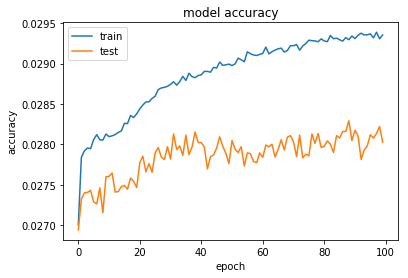

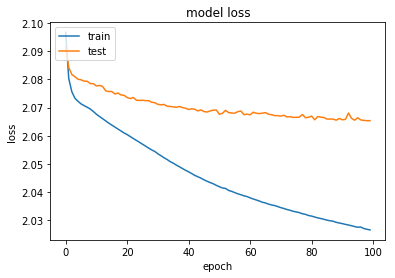

In [63]:
history = model.history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Evaluation 

In [54]:
def evaluate_model(raw_dataset, decoder_input_data, encoder_input_data, print_examples=False):
    inv_target_tokenizer = {v: k for k, v in target_tokenizer.items()}
    inv_input_tokenizer = {v: k for k, v in input_tokenizer.items()}
    actual, predicted = list(), list()

    for seq_index in tqdm(range(len(encoder_input_data))):  
        act = [inv_target_tokenizer[i] for i in decoder_input_data_te[seq_index] if inv_target_tokenizer[i] != "START_"]
        actual.append(act)
        
        input_seq = encoder_input_data[seq_index: seq_index + 1]
        input_img = np.array(reddit.image_feature[seq_index]).reshape(1,1,1000)
        pred = decode_sequence(input_img, decoder_model, input_tokenizer, target_tokenizer)
        predicted.append(pred)
        
        if print_examples:
            print("seq_index: [{}]".format(seq_index))
            title_text = [inv_input_tokenizer[i] for i in encoder_input_data_te[seq_index]]
            print("input: [{}]".format(" ".join(title_text)))
            url = raw_dataset.url[seq_index]
            display(IPython.display.Image(url, width = 250))
            print("target: [{}]".format(" ".join(act)))
            print("predicted: [{}] \n".format(" ".join(pred)))
            
    return corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))

def get_one_img(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    prediction_features = vgg19_model.predict(x)
    return prediction_features.ravel()

def user_input(input_words, img_feats, seq_len):
    input_seq = np.array([input_tokenizer[w] if w in input_tokenizer else 0 for w in input_words.split()] + 
                         [0] * (seq_len - len(input_words.split()))).reshape(1, seq_len)
    input_img = np.array(img_feats.reshape(1,1,1000))
    inv_input_token_index = {v: k for k, v in input_tokenizer.items()}
    #print("raw input: [{}] {}".format(" ".join([inv_input_token_index[i] for i in input_seq[0]]), input_seq.shape))
    decoded_sentence = decode_sequence(input_seq, input_img, encoder_model, decoder_model, input_tokenizer, target_tokenizer)
    return " ".join(decoded_sentence).replace("START_ ", "").replace(" _END","")

In [ ]:
evaluate_model(reddit_test, encoder_input_data_te, decoder_input_data_te, print_examples=False)